##멋진 단어사전 만들기

Korean Parallel Corpora
<br/>데이터 정보
<br/>데이터 탐색
<br/>SentencePiece
<br/>Tokenizer


Naver sentiment movie corpus
<br/>데이터 정보
<br/>데이터 탐색

SentencePiece
<br/>Corpus
<br/>Config
<br/>Common Class
<br/>Decoder
<br/>GPT-1
<br/>Data Loader
<br/>모델 학습
<br/>모델 평가

MeCab
<br/>Corpus
<br/>GPT-1
<br/>모델 학습
<br/>모델 평가

결론
<br/>참고문헌

#개발 환경

In [ ]:
!pip install sentencepiece

In [ ]:
!pip install wget

In [ ]:
import os
# install konlpy, jdk, JPype
!pip install konlpy
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip3 install JPype1-py3

# install mecab-ko
os.chdir('/tmp/')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
!tar zxfv mecab-0.996-ko-0.9.2.tar.gz
os.chdir('/tmp/mecab-0.996-ko-0.9.2')
!./configure
!make
!make check
!make install

# install mecab-ko-dic
!apt-get install automake
os.chdir('/tmp')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz
!tar -zxvf mecab-ko-dic-2.1.1-20180720.tar.gz
os.chdir('/tmp/mecab-ko-dic-2.1.1-20180720')
!./autogen.sh
!./configure
!make
!make install

# install mecab-python
os.chdir('/content')
!git clone https://bitbucket.org/eunjeon/mecab-python-0.996.git
os.chdir('/content/mecab-python-0.996')
!python3 setup.py build
!python3 setup.py install

In [ ]:
import random
import json
from collections import Counter
import warnings

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [ ]:
import wget
from tqdm import tqdm, tqdm_notebook, trange
from IPython.display import display
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

wget은 모델 학습의 bar 디자인과 모델의 다운로드 위치를 변경한다.
<br/>tqdm은 for문의 작업진행률을 표시한다.
<br/>IPython은 Jupyter Notebook의 파일에서 이미지를 표시한다.

In [ ]:
import re
import sentencepiece as spm
from konlpy.tag import Mecab

토크나이저의 방식은 크게 두가지 방식으로 나뉜다.
<br/><br/>Wordpiece
<br/>한 단어를 세부 단어로 분리한다.
<br/>SetencePiece. BPE. BERT WordPiece. 
<br/><br/>Morphology
<br/>형태소 분석을 한다.
<br/>Mecab. Okt. Komoran. Kkma. Hannanum. Khaiii
<br/>*Package : Huggingface Tokenizers

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import argparse
import collections
import shutil
import zipfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip freeze > '/content/drive/MyDrive/lms/library_version.txt'

In [ ]:
library_name = ['random', 'jsonschema=', 'tensorflow=', 'pandas=', 
                 'numpy=', 'wget', 'tqdm', 'matplotlib=',
                'regex=', 'sentencepiece=', 'konlpy', 'mecab', 'torch @']
library_version = []
f = open('/content/drive/MyDrive/lms/library_version.txt', 'r')
line = f.readline()
while True:
    line = f.readline()
    if not line:
      break
    for i in library_name:
      if i in line:
        library_version.append(line)
        library_version.append('    ')

f.close()

import sys
print(sys.version)
print()

for i in range(0, len(library_version) - 1, 6):
  print(str(library_version[i : i+6]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='') 
  if i % 6 == 0:
    print()

for i in range(len(library_version) - 1):
  if (i-1) % 6 == 0 and i == len(library_version) - 6:
    print(str(library_version[-1]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='')

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

fastjsonschema==2.15.3      jsonschema==4.3.3      konlpy==0.6.0     
matplotlib==3.2.2      mecab-python===0.996-ko-0.9.2      numpy==1.21.6     
pandas==1.3.5      regex==2022.6.2      sentencepiece==0.1.96     
sklearn-pandas==1.8.0      tensorflow==2.8.2+zzzcolab20220527125636      torch @ https://download.pytorch.org/whl/cu113/torch-1.11.0%2Bcu113-cp37-cp37m-linux_x86_64.whl     
tqdm==4.64.0      wget==3.2     


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Google Colab에서 할당된 GPU를 확인한다.
<br/>고용량 메모리 VM에 액세스한다.

#Korean Parallel Corpora

##데이터 정보

[Korean Parallel Corpora](https://github.com/jungyeul/korean-parallel-corpora)

한국어의 형태소 분석과 품사 태깅, 기계 번역 연구를 위해 공개된 데이터이다.

한국어-영어 뉴스 병렬 코퍼스
<br/>한국어-영어 Junior High Evaluation 병렬 코퍼스
<br/>한국어-프랑스 병렬 코퍼스
<br/>북한어-영어 병렬 코퍼스

[Korean English News V1](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

한국어-영어 뉴스 병렬 코퍼스에서 한국어 부분을 데이터로 사용한다.

##데이터 탐색

In [ ]:
path_to_file = '/content/drive/MyDrive/lms/sp_tokenizer/korean_parallel_corpora/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size :", len(raw))
print()
print("Example")
for sen in raw[600:700][::20]: print("", sen)

Data Size : 94123

Example
 앞서가고 있는 은행 중의 하나가 오하이오 주 콜럼버스에 있는 헌팅턴 뱅크쉐어즈이다.
 우리 내부의 신체 시계는 밤 에 자고, 낮 에 사냥하는 그러한 세계에 최적의 상태로 적응되어 있습니다."
 하지만 얼마나 오래 그 효과가 지속될 것인가?
 그 이름이 뜻하는 바와 같이 이 세균은 이미 밴코마이신과 모든 다른 항생물질에 대해 면역성을 갖게 되었다.
 하나의 통신망은 모뎀이나 케이블에 의해 호스트 컴퓨터나 서버에 접속되어 있는 일단의 컴퓨터들을 말한다.


문장의 최소 길이 : 1
문장의 최대 길이 : 377
문장의 평균 길이 : 60



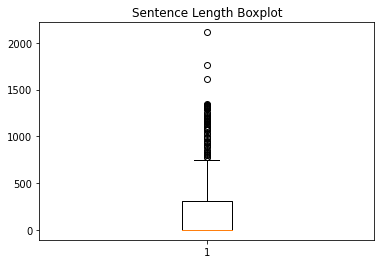

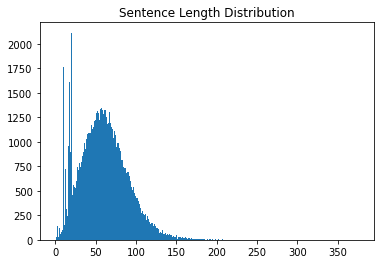

In [ ]:
warnings.filterwarnings(action='ignore')

min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최소 길이 :", min_len)
print("문장의 최대 길이 :", max_len)
print("문장의 평균 길이 :", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

print()
plt.boxplot(sentence_length)
plt.title("Sentence Length Boxplot")
plt.show()

print()
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [ ]:
for idx, _sum in enumerate(sentence_length):
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


문장의 수가 1500을 초과하는 문장의 인덱스를 확인한다.

In [ ]:
def check_sentence_with_length_list(raw, length):
    sentence = []
    count = 0

    for sen in raw:
        if len(sen) == length:
            sentence.append(sen)
            sentence.append('    ')
            count += 1
            if count > 100: return sentence

    return sentence

In [ ]:
def check_sentence_with_length_print(raw, length):

  sentence = check_sentence_with_length_list(raw, length)

  for i in range(0, len(sentence) - 1, 6):
    print(str(sentence[i : i+6]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='') 
    if i % 6 == 0:
      print()
    
  for i in range(len(sentence) - 1):
    if (i-1) % 6 == 0 and i == len(sentence) - 6:
      print(str(sentence[-1]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='')

In [ ]:
check_sentence_with_length_print(raw, 1)

’     


길이가 1인 문장을 출력한다.
<br/>아무것도 나오지 않는 결측치이다.

In [ ]:
check_sentence_with_length_print(raw, 11)

라고 조던이 말했다.      - 모르고 있습니다.      - 네 보이는군요.     
디즈니사만이 아니다.      큰 파티는 아니지요.      의자는 비어 있었다.     
이 일은 계속됩니다.      나는 크게 실망했다.      그 이유는 간단하다.     
이력서와 자기 소개서      시대가 변하고 있다.      는 돌발질문을 했다.     
9. 몇 분간의 명상      하와이 빅 아일랜드      키스를 잘 하는 방법     
키스를 잘 하는 방법      스피어스가 뚱뚱한가?      산 위를 나는 느낌.     
세 시간쯤 걸었을까?      (아직 읽고있습니까?      처음에는 장난이었다.     
우리는 운이 좋았다.      아기가 숨을 멈출 때      건물 전체 무너져내려     
그녀의 아름다운 눈.      대답은 다음과 같다.      "사과할 것이 없다.     
폭탄테러가 공포 유발      그는 "잘 모르겠다.      그는 "잘 모르겠다.     
그는 "잘 모르겠다.      그는 "잘 모르겠다.      그는 "잘 모르겠다.     
그는 "잘 모르겠다.      그는 "잘 모르겠다.      그는 "잘 모르겠다.     
그는 "잘 모르겠다.      케냐 야생동물 고아원      경유 1200원대로…     
더 내려야 하는 이유      케냐 야생동물 고아원      경유 1200원대로…     
더 내려야 하는 이유      케냐 야생동물 고아원      경유 1200원대로…     
더 내려야 하는 이유      케냐 야생동물 고아원      경유 1200원대로…     
더 내려야 하는 이유      케냐 야생동물 고아원      경유 1200원대로…     
더 내려야 하는 이유      케냐 야생동물 고아원      경유 1200원대로…     
더 내려야 하는 이유      케냐 야생동물 고아원      경유 1200원대로…     
더 내려야 하는 이유      케냐 야생동물 고아원     

길이가 11인 문장을 출력한다.
<br/>중복된 문장을 확인한다.

In [ ]:
cleaned_corpus = list(set(raw))

set을 사용해서 중복을 제거한다.

In [ ]:
check_sentence_with_length_print(cleaned_corpus, 11)

비관적인 염세주의의      의자는 비어 있었다.      제발 답변을 주세요!     
대답은 다음과 같다.      그들은 신중했습니다.      스피어스가 뚱뚱한가?     
건물 전체 무너져내려      끌어내다 철수시키다      hearing 청문회     
키스를 잘 하는 방법      - 모르고 있습니다.      원문기사 원문기사보기     
폭탄테러가 공포 유발      (정당의) 원내 총무      좀 더 말씀해주시죠.     
고 소식통이 전했다.      대통령 후보자의 지명      나는 크게 실망했다.     
resign 사퇴하다      levee 제방 둑      meantime 한편     
tribunal 법정      raft 다수 다량      Congress 의회     
본서 본부 사령부      하와이 빅 아일랜드      크라이슬러. 조업중단     
더 내려야 하는 이유      9. 몇 분간의 명상      조금은 새침한 샬롯？     
외교통상부 이슬람교도      아기가 숨을 멈출 때      시대가 변하고 있다.     
지하철 타기 겁난다.      (아직 읽고있습니까?      큰 파티는 아니지요.     
이전 보기 다음 보기      그는 "잘 모르겠다.      그 이유는 간단하다.     
이 일은 계속됩니다.      "천재 소녀의 부활"      처음에는 장난이었다.     
산 위를 나는 느낌.      pledge 서약하다      standard 표준     
경유 1200원대로…      라고 조던이 말했다.      작은 못이 아닙니다.     
로그인 Korea사전      우리는 운이 좋았다.      이력서와 자기 소개서     
정권을 잡다장악하다      원화 강세 언제까지?      전유를 넣은 카페라떼     
세 시간쯤 걸었을까?      케냐 야생동물 고아원      - 네 보이는군요.     
미래의 최첨단 사무실      "사과할 것이 없다.      디즈니사만이

Data Size : 77591
문장의 최소 길이 : 1
문장의 최대 길이 : 377
문장의 평균 길이 : 64



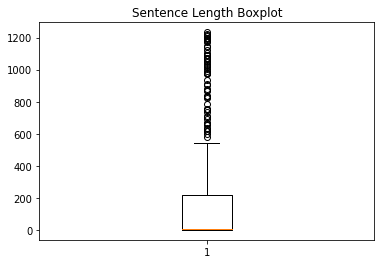

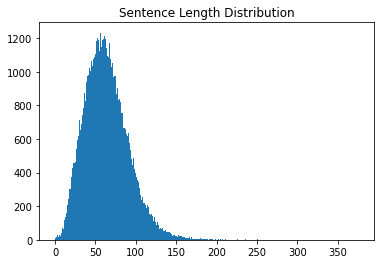

In [ ]:
min_len = 999
max_len = 0
sum_len = 0

print("Data Size :", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최소 길이 :", min_len)
print("문장의 최대 길이 :", max_len)
print("문장의 평균 길이 :", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1


print()
plt.boxplot(sentence_length)
plt.title("Sentence Length Boxplot")
plt.show()

print()
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

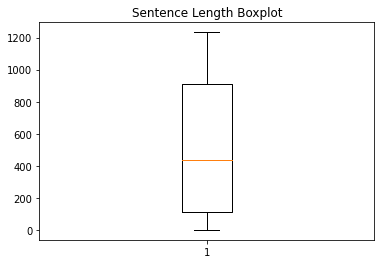

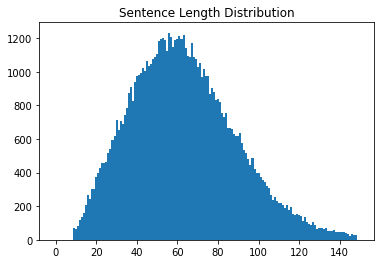

In [ ]:
max_len = 150
min_len = 10

filtered_corpus = [i for i in cleaned_corpus if (len(i) < max_len) & (len(i) >= min_len)]

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

print()
plt.boxplot(sentence_length)
plt.title("Sentence Length Boxplot")
plt.show()

print()
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

길이 조건에 맞는 문장을 선택한다.
<br/>문장의 최소 길이 10, 최대 길이 150으로 설정한다.

##SentencePiece

In [ ]:
temp_file = '/content/drive/MyDrive/lms/sp_tokenizer/korean_parallel_corpora/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in cleaned_corpus:   
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)

!ls -l korean_spm*

-rw-r--r-- 1 root root 376722 Jul  6 00:10 korean_spm.model
-rw-r--r-- 1 root root 146141 Jul  6 00:10 korean_spm.vocab


corpus를 활용해 sentencepiece 학습한 모델과 단어 사전을 만든다.
<br/>Train에서  model_type = 'unigram'이 디폴트 적용된다.
<br/>model_type = 'bpe' 로 옵션을 주어 변경할 수 있다.

In [ ]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

In [ ]:
def sentencepiece_process_input(sentence):
  number_list = []
  sentence_list = []
  
  for i in range(0, len(sentence), 2):
    number_list.append(i)

  for i in range(3):
    j = int(random.choice(number_list))
    sentence_list.append("".join(str(j) for j in sentence[j:j+1]))
  return sentence_list

In [ ]:
cleaned_sentence_list = check_sentence_with_length_list(cleaned_corpus, 13)
sentence = sentencepiece_process_input(cleaned_sentence_list)

In [ ]:
print("Encoding")
for i in sentence:
  print(s.EncodeAsIds(i))
print()

print("Encoded Pieces")
for i in sentence:
  print(s.SampleEncodeAsPieces(i ,1, 0.0))
print()

print("Decoding")
for i in sentence:
  tokensIDs = s.EncodeAsIds(i)
  print(s.DecodeIds(tokensIDs))

Encoding
[1627, 983, 7367, 460, 270, 13, 5017]
[912, 13, 669, 1156, 1158]
[6892, 378, 265, 640, 1471, 5956]

Encoded Pieces
['▁p', 'le', 'dge', '▁서', '약', ',', '▁공약']
['▁은행', ',', '▁인터넷', '▁보안', '▁강화']
['▁pre', 'm', 'i', 'er', '▁최초', '▁상영']

Decoding
pledge 서약, 공약
은행, 인터넷 보안 강화
premier 최초 상영


길이가 13인 문장을 무작위로 3개 추출해 인코딩과 디코딩을 한다.

##Tokenizer

In [ ]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [ ]:
cleaned_sentence_list = check_sentence_with_length_list(cleaned_corpus, 9)
sentence = sentencepiece_process_input(cleaned_sentence_list)

In [ ]:
print(sentence)
tensor, word_index, index_word = sp_tokenize(s, sentence)
print()
print(tensor)

['내 블로그에 저장', '서식환경, 서식지', '영화 대여 서비스']

[[ 120 3171 2150    0    0]
 [ 460  249 6826   13 6264]
 [ 210  184  221 1180    0]]


길이가 9인 문장을 무작위로 3개 추출해 인코딩한다.

In [ ]:
def word_with_index_print(word_with_index):

  r = list(range(len(word_with_index)))
  random.shuffle(r)

  print("Word Index")

  for i in r[:10]:
    print(i, ':', word_with_index[i])
  print()

  print("Index Word")
  
  for i in r[:10]:
    print(word_with_index[i], ":", i)

In [ ]:
word_with_index_print(word_index)

Word Index
7700 : 셍
1215 : ▁골
2538 : ▁확대
7612 : 쳇
6723 : ▁착수했다
2034 : 측은
2953 : ▁겪고
7763 : 쌀
5412 : ▁공개된
5086 : 받았다

Index Word
셍 : 7700
▁골 : 1215
▁확대 : 2538
쳇 : 7612
▁착수했다 : 6723
측은 : 2034
▁겪고 : 2953
쌀 : 7763
▁공개된 : 5412
받았다 : 5086


무작위로 word_index와 index_word를 추출한다.

#Naver sentiment movie corpus

##데이터 정보

[Naver sentiment movie corpus v1.0](https://github.com/e9t/nsmc)

네이버 영화 리뷰 댓글을 웹크롤링한 한국어 말뭉치 데이터셋이다.

데이터셋 구축 과정은 [Large Movie Review Dataset v1.0](https://ai.stanford.edu/~amaas/data/sentiment/)의 구성 방식에 기초한다. 
<br/>Large Movie Review Dataset은 IMDB에서 영화 5만편의 작품 리뷰를 웹크롤링한 말뭉치 데이터셋이다.
<br/>그 중에 훈련 데이터로 쓰일 2만5천개의 리뷰, 시험 데이터로 쓰일 2만5천개의 리뷰로 구성된다.
<br/>그리고 긍정적인 리뷰 2만5천개, 부정적인 리뷰 2만5천개로 구성된다.

데이터셋 분석 결과를 통해 논문 Learning Word Vectors for Sentiment Analysis을 작성했다.
<br/>이 데이터로 학습시킨 모델의 성능은 88.89%의 정확도에 달한다.

Naver Sentiment Movie Corpus v1.0(NSMC)은 훈련 데이터로 쓰일 15만개의 리뷰,
<br/>시험 데이터로 쓰일 5만개의 리뷰로 구성된다.
<br/>그리고 긍정적인 리뷰 1만개, 부정적인 리뷰 1만개로 구성된다.

모든 리뷰의 글자수는 140자 이하이다.
<br/>긍정과 부정의 수치는 1부터 10까지로 정수로 부여한다.
<br/>중립적인 의견의 리뷰는 데이터셋에서 제외한다.

##데이터 탐색

In [ ]:
train_data = pd.read_table("/content/drive/MyDrive/lms/film_review/ratings_train.txt")
test_data = pd.read_table("/content/drive/MyDrive/lms/film_review/ratings_test.txt")

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
train_data['document'].to_csv("/content/drive/MyDrive/lms/film_review/sp_tokenizer/train.csv", index = False)

문자열이 포함된 행을 추출하여 데이터프레임을 만든다.

In [ ]:
with open("/content/drive/MyDrive/lms/film_review/sp_tokenizer/train.csv", "r") as f:
    raw = f.read().splitlines()

movie_raw = raw[1:]
print("Data Size :", len(movie_raw))
print()
print("Example")
for sen in movie_raw[:100][::20]: print("", sen)

Data Size : 150000

Example
 아 더빙.. 진짜 짜증나네요 목소리
 나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님
 단순하면서 은은한 매력의 영화
 보는내내 그대로 들어맞는 예측 카리스마 없는 악역
 뭐냐..시작하고 3분만에 나왔다. 리플릿 사진 보며 불안하더니만..


문장의 최소 길이 : 1
문장의 최대 길이 : 158
문장의 평균 길이 : 35



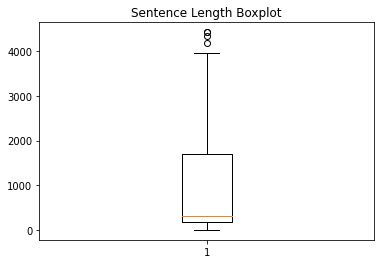

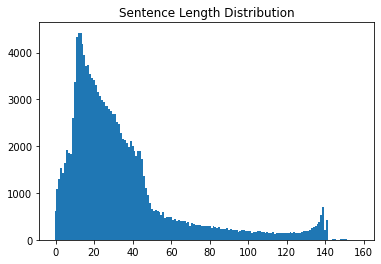

In [ ]:
warnings.filterwarnings(action='ignore')

min_len = 999
max_len = 0
sum_len = 0

for sen in movie_raw :
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최소 길이 :", min_len)
print("문장의 최대 길이 :", max_len)
print("문장의 평균 길이 :", sum_len // len(movie_raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in movie_raw:
    sentence_length[len(sen)-1] += 1

print()
plt.boxplot(sentence_length)
plt.title("Sentence Length Boxplot")
plt.show()

print()
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

##SentencePiece

###Corpus

[kowiki.txt](https://paul-hyun.github.io/nlp-tutorial-02-02-tokenizer/)

In [ ]:
corpus = "/content/drive/MyDrive/lms/sp_tokenizer/kowikitext/kowiki.txt"
prefix = "kowiki"
vocab_size = 8000
spm.SentencePieceTrainer.train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + 
    " --pad_id=0 --pad_piece=[PAD]" + 
    " --unk_id=1 --unk_piece=[UNK]" + 
    " --bos_id=2 --bos_piece=[BOS]" + 
    " --eos_id=3 --eos_piece=[EOS]" + 
    " --user_defined_symbols=[SEP],[CLS],[MASK]") 

corpus는 학습용 말뭉치이다.
<br/>prefix는 저장할 vocab 이름이다.
<br/>vocab_size에 7를 더한다. 7은 특수문자 개수이다.
<br/>model_type은 bpe이다.
<br/>max_sentence_length를 default 999999로 설정한다.
<br/>token은 [PAD], [UNK], [BOS], [EOS], [SEP], [CLS], [MASK]으로 구성된다.
<br/>pad_id는 0, unk_id는 1, bos_id는 2, eos_id는 3으로 설정한다.
<br/>bos는 begin of sequence, eos는 end of sequence를 의미한다.
<br/>user_defined_symbols는 모델 구성을 위한 [SEP] : 4, [CLS] : 5, [MASK] : 6으로 설정한다.

In [ ]:
vocab = spm.SentencePieceProcessor()
vocab.load("kowiki.model")

In [ ]:
sentence_list = check_sentence_with_length_list(movie_raw, 19)
sentence = sentencepiece_process_input(sentence_list)

In [ ]:
for line in sentence:
  pieces = vocab.encode_as_pieces(line)
  ids = vocab.encode_as_ids(line)
  print(line)
  print(pieces)
  print(ids)
  print()

기대이상으로 사랑스러운 영화네 ㅋㅋ
['▁기', '대', '이', '상으로', '▁사랑', '스', '러운', '▁영화', '네', '▁', 'ᄏ', 'ᄏ']
[23, 3612, 3588, 1300, 1421, 3618, 2615, 339, 3857, 3587, 7112, 7112]

안보면 인생을 낭비하는 것과 같다.
['▁안', '보', '면', '▁인', '생', '을', '▁', '낭', '비', '하는', '▁것과', '▁같다', '.']
[176, 3666, 3693, 44, 3737, 3598, 3587, 4427, 3684, 38, 2405, 533, 3590]

Sf영화에서 안좋은 모든 것을 갖춤
['▁S', 'f', '영화', '에서', '▁안', '좋', '은', '▁모든', '▁것을', '▁갖', '춤']
[225, 3854, 2275, 10, 176, 4151, 3604, 487, 341, 570, 4538]



길이가 19인 문장을 무작위로 3개 추출해 토크나이징과 인코딩을 한다.

In [ ]:
def prepare_train(vocab, infile, outfile):
    df = pd.read_csv(infile, sep="\t", engine="python")
    with open(outfile, "w") as f:
        for index, row in df.iterrows():
            document = row["document"]
            if type(document) != str:
                continue
            instance = { "id": row["id"], "doc": vocab.encode_as_pieces(document), "label": row["label"] }
            f.write(json.dumps(instance))
            f.write("\n")

In [ ]:
prepare_train(vocab, "/content/drive/MyDrive/lms/film_review/ratings_train.txt",
              "/content/drive/MyDrive/lms/sp_tokenizer/film_review/sentencepiece_ratings_train.json")

prepare_train(vocab, "/content/drive/MyDrive/lms/film_review/ratings_test.txt",
              "/content/drive/MyDrive/lms/sp_tokenizer/film_review/sentencepiece_ratings_test.json")

 ### Config

In [ ]:
class Config(dict): 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [ ]:
config = Config({
    "n_dec_vocab": len(vocab),
    "n_dec_seq": 256,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_dec_vocab': 8007, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


###Common Class

In [ ]:
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

In [ ]:
def get_attn_pad_mask(seq_q, seq_k, i_pad):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(i_pad).unsqueeze(1).expand(batch_size, len_q, len_k)  # <pad>
    return pad_attn_mask

In [ ]:
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask

In [ ]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.dropout)
        self.scale = 1 / (self.config.d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        attn_prob = self.dropout(attn_prob)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(self.config)
        self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        output = self.dropout(output)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

In [ ]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_ff, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        output = self.dropout(output)
        # (bs, n_seq, d_hidn)
        return output

###Decoder

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, dec_inputs, self_attn_mask):
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq)
        self_att_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask)
        self_att_outputs = self.layer_norm1(dec_inputs + self_att_outputs)
        # (bs, n_dec_seq, d_hidn)
        ffn_outputs = self.pos_ffn(self_att_outputs)
        ffn_outputs = self.layer_norm3(self_att_outputs + ffn_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)
        return ffn_outputs, self_attn_prob

In [ ]:
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, dec_inputs):
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1
        pos_mask = dec_inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)
    
        # (bs, n_dec_seq, d_hidn)
        dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions)

        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad)
        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs)
        # (bs, n_dec_seq, n_dec_seq)
        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)

        self_attn_probs = []
        for layer in self.layers:
            # (bs, n_dec_seq, d_hidn), (bs, n_dec_seq, n_dec_seq)
            dec_outputs, self_attn_prob = layer(dec_outputs, dec_self_attn_mask)
            self_attn_probs.append(self_attn_prob)
        # (bs, n_dec_seq, d_hidn), [(bs, n_dec_seq, n_dec_seq)]
        return dec_outputs, self_attn_probs

### GPT-1

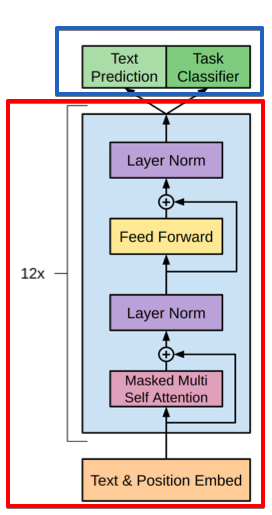

In [ ]:
Image(filename='/content/drive/MyDrive/lms/sp_tokenizer/GPT.png') 

In [ ]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.decoder = Decoder(self.config)
    
    def forward(self, dec_inputs):
        # (bs, n_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)]
        dec_outputs, dec_self_attn_probs = self.decoder(dec_inputs)
        # (bs, n_dec_seq, n_dec_vocab), [(bs, n_head, n_dec_seq, n_dec_seq)]
        return dec_outputs, dec_self_attn_probs
    
    def save(self, epoch, loss, path):
        torch.save({
            "epoch": epoch,
            "loss": loss,
            "state_dict": self.state_dict()
        }, path)
    
    def load(self, path):
        save = torch.load(path)
        self.load_state_dict(save["state_dict"])
        return save["epoch"], save["loss"]

In [ ]:
class MovieClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.gpt = GPT(self.config)
        # lm
        self.projection_lm = nn.Linear(self.config.d_hidn, self.config.n_dec_vocab, bias=False)
        self.projection_lm.weight = self.gpt.decoder.dec_emb.weight
        # classfier
        self.projection_cls = nn.Linear(self.config.d_hidn, self.config.n_output, bias=False)
    
    def forward(self, dec_inputs):
        # (bs, n_dec_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)]
        dec_outputs, dec_self_attn_probs = self.gpt(dec_inputs)
        # (bs, n_dec_seq, n_dec_vocab)
        logits_lm = self.projection_lm(dec_outputs)
        # (bs, d_hidn)
        dec_outputs = dec_outputs[:, -1].contiguous()
        # (bs, n_output)
        logits_cls = self.projection_cls(dec_outputs)
        # (bs, n_dec_seq - 1, n_dec_vocab), (bs, n_output), [(bs, n_head, n_dec_seq, n_dec_seq)]
        return logits_lm[:, :-1, :].contiguous(), logits_cls, dec_self_attn_probs

###Data Loader

In [ ]:
class MovieDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.labels = []
        self.sentences = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            for i, line in enumerate(tqdm(f, total=line_cnt, desc=f"Loading {infile}", unit=" lines")):
                data = json.loads(line)
                self.labels.append(data["label"])
                self.sentences.append([vocab.piece_to_id("[BOS]")] + [vocab.piece_to_id(p) for p in data["doc"]] + [vocab.piece_to_id("[EOS]")])
    
    def __len__(self):
        assert len(self.labels) == len(self.sentences)
        return len(self.labels)
    
    def __getitem__(self, item):
        return (torch.tensor(self.labels[item]),
                torch.tensor(self.sentences[item]))

In [ ]:
def movie_collate_fn(inputs):
    labels, dec_inputs = list(zip(*inputs))

    dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=0)

    batch = [
        torch.stack(labels, dim=0),
        dec_inputs,
    ]
    return batch

In [ ]:
batch_size = 128
train_dataset = MovieDataSet(vocab, "/content/drive/MyDrive/lms/sp_tokenizer/film_review/sentencepiece_ratings_train.json")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True, collate_fn=movie_collate_fn)

test_dataset = MovieDataSet(vocab, "/content/drive/MyDrive/lms/sp_tokenizer/film_review/sentencepiece_ratings_test.json")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, collate_fn=movie_collate_fn)

Loading /content/drive/MyDrive/lms/sp_tokenizer/film_review/ratings_train.json: 100%|██████████| 149995/149995 [00:05<00:00, 28494.57 lines/s]
Loading /content/drive/MyDrive/lms/sp_tokenizer/film_review/ratings_test.json: 100%|██████████| 49997/49997 [00:01<00:00, 25804.78 lines/s]


###모델 학습

In [ ]:
def train_epoch(config, epoch, model, criterion_cls, optimizer, train_loader):
    losses = []
    model.train()

    with tqdm(total=len(train_loader), desc=f"Train({epoch})") as pbar:
        for i, value in enumerate(train_loader):
            labels, dec_inputs = map(lambda v: v.to(config.device), value)

            optimizer.zero_grad()
            outputs = model(dec_inputs)
            logits_cls = outputs[1]

            loss_cls = criterion_cls(logits_cls, labels)
            loss = loss_cls

            loss_val = loss_cls.item()
            losses.append(loss_val)

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

In [ ]:
def eval_epoch(config, model, data_loader):
    matchs = []
    model.eval()

    n_word_total = 0
    n_correct_total = 0
    with tqdm(total=len(data_loader), desc=f"Valid") as pbar:
        for i, value in enumerate(data_loader):
            labels, dec_inputs = map(lambda v: v.to(config.device), value)

            outputs = model(dec_inputs)
            logits_cls = outputs[1]
            _, indices = logits_cls.max(1)

            match = torch.eq(indices, labels).detach()
            matchs.extend(match.cpu())
            accuracy = np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

            pbar.update(1)
            pbar.set_postfix_str(f"Acc: {accuracy:.3f}")
    return np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

In [ ]:
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.n_output = 2
print(config)

learning_rate = 5e-5
n_epoch = 10

{'n_dec_vocab': 8007, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'device': device(type='cuda'), 'n_output': 2}


In [ ]:
def train(model):
    model.to(config.device)

    criterion_cls = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_epoch, best_loss, best_score = 0, 0, 0
    losses, scores = [], []
    for epoch in range(n_epoch):
        loss = train_epoch(config, epoch, model, criterion_cls, optimizer, train_loader)
        score = eval_epoch(config, model, test_loader)

        losses.append(loss)
        scores.append(score)

        if best_score < score:
            best_epoch, best_loss, best_score = epoch, loss, score
    print(f">>>> epoch={best_epoch}, loss={best_loss:.5f}, socre={best_score:.5f}")
    return losses, scores

In [ ]:
model = MovieClassification(config)
sentencepiece_losses, sentencepiece_accuracy = train(model)

Valid: 100%|██████████| 391/391 [00:48<00:00,  8.02it/s, Acc: 0.839]


>>>> epoch=9, loss=0.25584, socre=0.83891


###모델 평가

,Loss,Accuracy
0,0.488845,0.795468
1,0.408942,0.814009
2,0.383089,0.818049
3,0.362958,0.828190
4,0.343607,0.830110
5,0.326295,0.835150
6,0.310044,0.835890
7,0.292093,0.836990
8,0.274038,0.838030
9,0.255835,0.838910


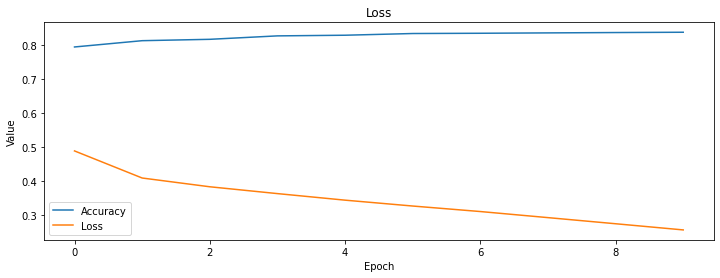

In [ ]:
data = {
    "Loss": sentencepiece_losses,
    "Accuracy": sentencepiece_accuracy,
}
df = pd.DataFrame(data)
display(df)
print()

plt.figure(figsize=[12, 4])
plt.plot(sentencepiece_losses, label="Loss")
plt.plot(sentencepiece_accuracy, label="Accuracy")
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

##MeCab

###Corpus

In [ ]:
kowiki_file = "/content/drive/MyDrive/lms/sp_tokenizer/kowikitext/kowiki.zip"

In [ ]:
args = {
    "seed": 1234,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "corpus": kowiki_file,
}
args = argparse.Namespace(**args)

print(args)

Namespace(corpus='/content/drive/MyDrive/lms/sp_tokenizer/kowikitext/kowiki.zip', device=device(type='cuda'), seed=1234)


환경 설정을 한다.
<br/>random seed value를 1234로 설정한다.
<br/>CPU 또는 GPU 사용여부를 결정한다.
<br/>말뭉치 파일을 만든다.

In [ ]:
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

In [ ]:
mecab = Mecab()

In [ ]:
with open("/content/drive/MyDrive/lms/sp_tokenizer/kowikitext/kowiki_mecab.txt", "w") as o_f:
    with zipfile.ZipFile(args.corpus) as z:
        with z.open("kowiki.txt") as f:
            for i, line in enumerate(f):
                line = line.decode('utf-8').strip()
                tokens = mecab.morphs(line)
                string = " ".join(tokens)
                o_f.write(string)
                o_f.write("\n")

morph 단위로 분할된 말뭉치를 생성한다.

In [ ]:
print(os.listdir("./"))

['setup.py', '.git', 'GPL', 'build', '__pycache__', 'bindings.html', 'README', 'BSD', 'MeCab_wrap.cxx', 'AUTHORS', 'COPYING', 'test.py', 'LGPL', 'README.md', 'MeCab.py']


In [ ]:
def train_sentencepiece(corpus, prefix, vocab_size=8000):

    spm.SentencePieceTrainer.train(
        f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size + 7}" +  
        " --model_type=unigram" +
        " --max_sentence_length=999999" +  
        " --pad_id=0 --pad_piece=[PAD]" + 
        " --unk_id=1 --unk_piece=[UNK]" +  
        " --bos_id=2 --bos_piece=[BOS]" +  
        " --eos_id=3 --eos_piece=[EOS]" +  
        " --user_defined_symbols=[SEP],[CLS],[MASK]" +  
        " --input_sentence_size=100000" +  
        " --shuffle_input_sentence=true")  

corpus는 학습용 말뭉치이다.
<br/>prefix는 저장할 vocab 이름이다.
<br/>vocab_size에 7를 더한다. 7은 특수문자 개수이다.
<br/>model_type은 bpe이다.
<br/>max_sentence_length를 default 999999로 설정한다.
<br/>token은 [PAD], [UNK], [BOS], [EOS], [SEP], [CLS], [MASK]으로 구성된다.
<br/>pad_id는 0, unk_id는 1, bos_id는 2, eos_id는 3으로 설정한다.
<br/>bos는 begin of sequence, eos는 end of sequence를 의미한다.
<br/>user_defined_symbols는 모델 구성을 위한 [SEP] : 4, [CLS] : 5, [MASK] : 6으로 설정한다.
<br/>input_sentence_size는 말뭉치에서 샘플링하여 학습한다.
<br/>shuffle_input_sentence는 샘플링한 말뭉치를 shuffle한다.

In [ ]:
train_sentencepiece("/content/drive/MyDrive/lms/sp_tokenizer/kowikitext/kowiki_mecab.txt", "kowiki_mecab")

In [ ]:
print(os.listdir("./"))

['setup.py', 'kowiki_mecab.model', '.git', 'GPL', 'build', '__pycache__', 'bindings.html', 'README', 'BSD', 'MeCab_wrap.cxx', 'AUTHORS', 'COPYING', 'kowiki_mecab.vocab', 'test.py', 'LGPL', 'README.md', 'MeCab.py']


In [ ]:
corpus_dir = os.path.dirname(args.corpus)
shutil.copy("kowiki_mecab.model", corpus_dir)
shutil.copy("kowiki_mecab.vocab", corpus_dir)

print(os.listdir(corpus_dir))

['kowiki.txt', 'kowiki.zip', 'kowiki_mecab.txt', 'kowiki_mecab.model', 'kowiki_mecab.vocab']


In [ ]:
spm_vocab = spm.SentencePieceProcessor()
spm_vocab.load(os.path.join(corpus_dir, "kowiki_mecab.model"))

In [ ]:
sentence_list = check_sentence_with_length_list(movie_raw, 20)
sentence = sentencepiece_process_input(sentence_list)

In [ ]:
for line in sentence:
  pieces = spm_vocab.encode_as_pieces(line)
  ids = spm_vocab.encode_as_ids(line)
  print(line)
  print(pieces)
  print(ids)
  print()

제대하고 보니까 더 재밌네요 ㅋㅋㅋㅋ
['▁제', '대', '하', '고', '▁보', '니', '까', '▁더', '▁재', '밌', '네', '요', '▁', 'ᄏᄏᄏᄏ']
[71, 142, 74, 166, 154, 196, 2008, 249, 258, 7122, 573, 809, 7, 1]

재미만있구만 ㅋ뭔작품성따지고보냐 ㅋㅋ
['▁재', '미', '만', '있', '구', '만', '▁', 'ᄏ', '뭔', '작', '품', '성', '따', '지', '고', '보', '냐', '▁', 'ᄏᄏ']
[258, 183, 382, 5286, 136, 382, 7, 1, 7872, 687, 1072, 144, 4091, 53, 166, 199, 3103, 7, 1]

시나리오 연기 연출 모든면에서 좋았다
['▁시나', '리오', '▁연기', '▁연출', '▁모', '든', '면', '에', '서', '▁좋', '았', '다']
[3947, 1817, 1442, 3310, 150, 371, 191, 417, 93, 795, 4955, 123]



### GPT-1

In [ ]:
config = Config({
    "n_dec_vocab": len(spm_vocab),
    "n_dec_seq": 256,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_dec_vocab': 8007, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


In [ ]:
prepare_train(spm_vocab, "/content/drive/MyDrive/lms/film_review/ratings_train.txt",
              "/content/drive/MyDrive/lms/sp_tokenizer/film_review/mecab_ratings_train.json")

prepare_train(spm_vocab, "/content/drive/MyDrive/lms/film_review/ratings_test.txt",
              "/content/drive/MyDrive/lms/sp_tokenizer/film_review/mecab_ratings_test.json")

In [ ]:
batch_size = 128
train_dataset = MovieDataSet(spm_vocab, "/content/drive/MyDrive/lms/sp_tokenizer/film_review/mecab_ratings_train.json")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True, collate_fn=movie_collate_fn)

test_dataset = MovieDataSet(spm_vocab, "/content/drive/MyDrive/lms/sp_tokenizer/film_review/mecab_ratings_test.json")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, collate_fn=movie_collate_fn)

Loading /content/drive/MyDrive/lms/sp_tokenizer/film_review/mecab_ratings_train.json: 100%|██████████| 149995/149995 [00:05<00:00, 28120.59 lines/s]
Loading /content/drive/MyDrive/lms/sp_tokenizer/film_review/mecab_ratings_test.json: 100%|██████████| 49997/49997 [00:01<00:00, 30212.61 lines/s]


###모델 학습

In [ ]:
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.n_output = 2
print(config)

learning_rate = 5e-5
n_epoch = 10

{'n_dec_vocab': 8007, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'device': device(type='cuda'), 'n_output': 2}


In [ ]:
model = MovieClassification(config)
mecab_losses, mecab_accuracy = train(model)

Valid: 100%|██████████| 391/391 [00:53<00:00,  7.35it/s, Acc: 0.841]


>>>> epoch=7, loss=0.28692, socre=0.84205


### 모델 평가

,Loss,Accuracy
0,0.490261,0.806048
1,0.404277,0.818849
2,0.377093,0.824569
3,0.356641,0.831990
4,0.338119,0.837090
5,0.320748,0.839410
6,0.305006,0.841350
7,0.286919,0.842051
8,0.270789,0.839890
9,0.253703,0.841370


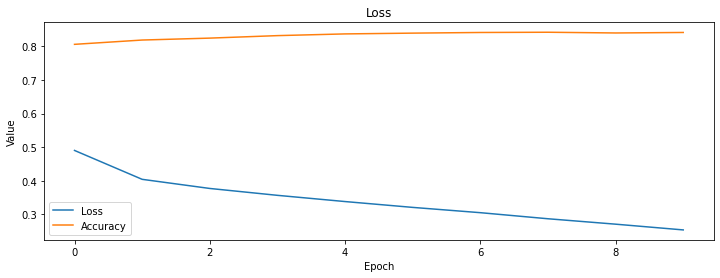

In [ ]:
data = {
    "Loss": mecab_losses,
    "Accuracy": mecab_accuracy,
}
df = pd.DataFrame(data)
display(df)
print()

plt.figure(figsize=[12, 4])
plt.plot(mecab_losses, label="Loss")
plt.plot(mecab_accuracy, label="Accuracy")
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

#결론

SentencePiece + GPT-1
<br/>Loss: 0.2558 - Accuracy: 0.8389


MeCab + GPT-1
<br/>Loss: 0.2537 - Accuracy: 0.8414


MeCab + GPT-1 모델의 성능이 더 높다.

#참고문헌

**LMS**
<br/>[dev-sngwn](https://github.com/dev-sngwn)

<br/>**논문**
<br/>[Alec Radford, Karthik Narasimhan, Tim Salimans, Ilya Sutskever, 「Improving Language Understanding by Generative Pre-Training」, OpenAI, 2018](https://openai.com/blog/language-unsupervised/)

<br/>**공식 사이트**
<br/>Korpora
<br/>[한국어 위키 텍스트](https://ko-nlp.github.io/Korpora/ko-docs/corpuslist/kowikitext.html)
<br/><br/>파이토치 한국 사용자 모임
<br/>[TORCH.NN 이 실제로 무엇인가요?](https://tutorials.pytorch.kr/beginner/nn_tutorial.html)

<br/>**깃허브**
<br/>jungyeul
<br/>[jungyeul/korean-parallel-corpora/korean-english-news-v1](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

<br/>cchyun
<br/>[paul-hyun/transformer-evolution/tutorial](https://github.com/paul-hyun/transformer-evolution/tree/master/tutorial)
<br/>[Sentencepiece를 활용해 Vocab 만들기](https://paul-hyun.github.io/vocab-with-sentencepiece/)
<br/>[Naver 영화리뷰 감정분석 데이터 전처리 하기](https://paul-hyun.github.io/preprocess-nsmc/)
<br/>[자연어처리를 위한 Tokenizer & Vocabulary](https://paul-hyun.github.io/nlp-tutorial-02-02-tokenizer/)
<br/>[GPT(Generative Pre-Training) 구현하기 (1/2)](https://paul-hyun.github.io/gpt-01/)
<br/>[GPT(Generative Pre-Training) 구현하기 (2/2)](https://paul-hyun.github.io/gpt-02/)

<br/>**웹사이트**
<br/>[python wget 사용하는 방법](https://my-devblog.tistory.com/18)
<br/>[Python에서 tqdm 라이브러리를 이용한 작업진행률 표시](http://www.gisdeveloper.co.kr/?p=8636)
<br/>[python Jupyter Notebook의 파일에서 이미지를 표시하려면 어떻게해야합니까?](http://daplus.net/python-jupyter-notebook%EC%9D%98-%ED%8C%8C%EC%9D%BC%EC%97%90%EC%84%9C-%EC%9D%B4%EB%AF%B8%EC%A7%80%EB%A5%BC-%ED%91%9C%EC%8B%9C%ED%95%98%EB%A0%A4%EB%A9%B4-%EC%96%B4%EB%96%BB%EA%B2%8C%ED%95%B4%EC%95%BC/)
<br/>[Tokenizer 비교 실험 (형태소 분석, word piece)](https://i-am-wendy.tistory.com/27)
<br/>[에러 해결: RuntimeError: CUDA error: device-side assert triggered](https://qlsenddl-lab.tistory.com/39)